In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Text preprocessing libraries
import string, subprocess
import nltk
import string, re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**LOAD THE DATA**

In [ ]:
data = pd.read_csv("tweets.csv", encoding='latin')
data.head()

,Target,ID,Date,flag,User,Text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# We just need two columns, including target and text
data = data[['Target', 'Text']]

In [ ]:
# Shape data
data.shape

(173778, 2)

In [ ]:
# The number of value count for each target columns
data['Target'].value_counts()

Target
0    173778
Name: count, dtype: int64

In [ ]:
# Adjusting target values
data['Target'] = data['Target'].replace(4, 1)

In [ ]:
data['Target'].value_counts()

Target
0    173778
Name: count, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173778 entries, 0 to 173777
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Target  173778 non-null  int64 
 1   Text    173778 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


In [ ]:
# Check the null values there in the dataset.
data.isnull().sum()

Target    0
Text      0
dtype: int64

In [ ]:
# Balancing the dataset
min_count = data['Target'].value_counts().min()
balanced_data = pd.concat([data[data['Target'] == target].sample(min_count, replace=False) for target in data['Target'].unique()])
data = balanced_data.sample(frac=1).reset_index(drop=True)

In [ ]:
# Explore data
print("Data Information:")
print(data.info())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173778 entries, 0 to 173777
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Target  173778 non-null  int64 
 1   Text    173778 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.7+ MB
None


**VISUALIZATION:**

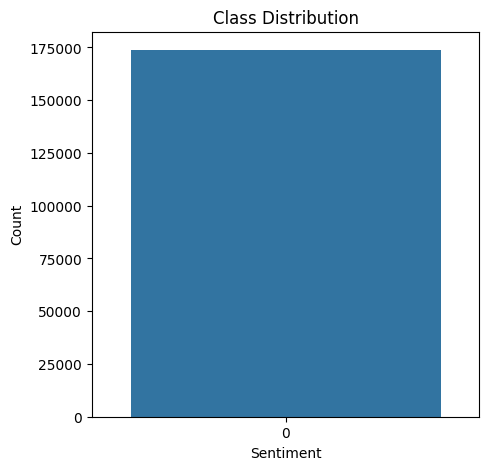

In [ ]:
# Visualize class distribution
plt.figure(figsize=(5, 5))
sns.countplot(x='Target' , data=data)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

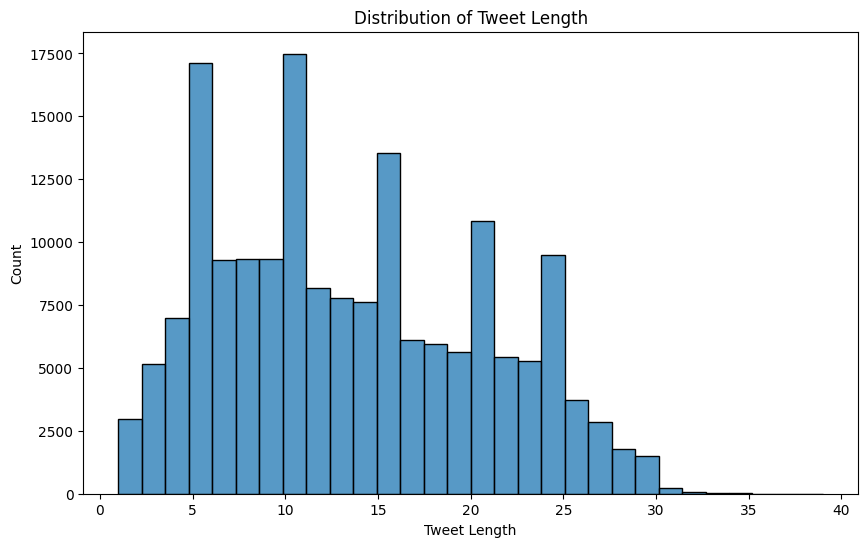

In [ ]:
# Explore tweet length
data['Tweet_Length'] = data['Text'].apply(lambda x: len(x.split()))

# Visualize tweet length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Tweet_Length'], bins=30)
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length')
plt.ylabel('Count')
plt.show()

In [ ]:
# Explore word frequency
all_words = ' '.join(data['Text'])
words = all_words.split()
word_freq = pd.Series(words).value_counts()

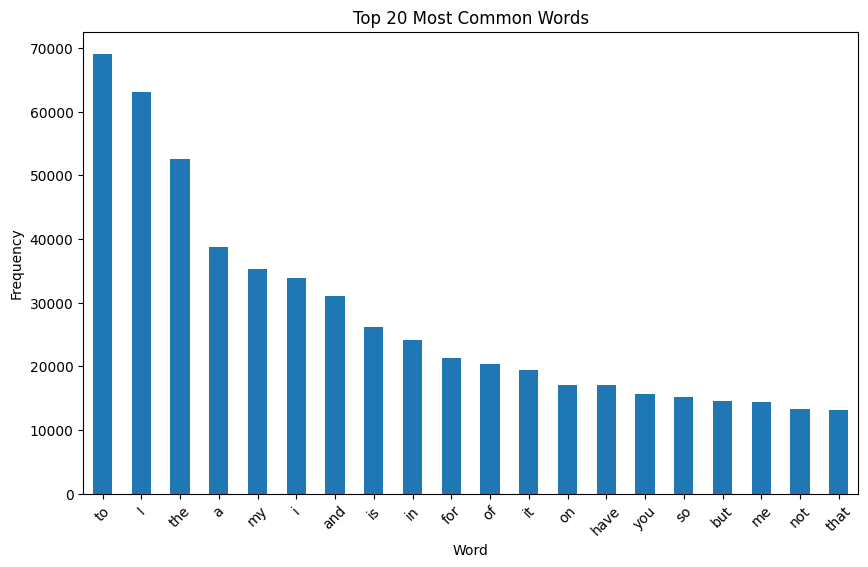

In [ ]:
# Visualize top 20 most common words
plt.figure(figsize=(10, 6))
word_freq[:20].plot(kind='bar')
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

**DATA PREPROCESSING**

In [ ]:
# Initialize the lemmatizer - used to reduce inflected words to their root word.
lemmatizer = WordNetLemmatizer()

In [ ]:
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')

except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!


**REMOVE SPECIAL CHARACTER IN REVIEW COLUMN:**

In [ ]:
stop_words = stopwords.words("english")

# Processing tweets
def process_tweets(review):
    review = review.lower()
    review = re.sub('^a-zA-Z0-9', ' ', review)
    review = re.sub('<.*?>', ' ', review)
    review = "".join([x for x in review if x not in string.punctuation])
    review = review.split()
    review = [lemmatizer.lemmatize(x) for x in review if x not in stop_words]
    review = " ".join(review)
    return review

In [ ]:
#processing to data
data['processed_tweets'] = data['Text'].apply(process_tweets)

**SPLITTING DATA INTO FEATURES AND TARGET:**

In [ ]:
X = data['processed_tweets'].values
y = data['Target'].values

In [ ]:
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Tokenize and pad sequences
max_words = 5000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

**MODEL-RNN:**

In [ ]:
embedding_dim = 100

model = Sequential()

model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          500000    
                                                                 
 lstm_6 (LSTM)               (None, 200, 128)          117248    
                                                                 
 lstm_7 (LSTM)               (None, 200, 64)           49408     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
# Define optimizer with an initial learning rate
initial_lr = 0.001
optimizer = Adam(learning_rate=initial_lr)

# Compile the model with optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True)

# Define a learning rate scheduler callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6)

**TRAIN THE MODEL:**

In [ ]:
history = model.fit(
    X_train, y_train, batch_size=124,
    callbacks=[early_stopping, reduce_lr_callback],
    validation_data=(X_test, y_test)
)

1122/1122 [==============================] - 2782s 2s/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 4.7429e-07 - val_accuracy: 1.0000 - lr: 0.0010


**EVALUATE THE MODEL:**

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

1087/1087 [==============================] - 157s 144ms/step - loss: 4.7429e-07 - accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000


In [ ]:
y_pred = model.predict(X_test)

# Convert y_pred to binary values
y_pred_binary = (y_pred > 0.5).astype(int)

1087/1087 [==============================] - 154s 141ms/step


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34756

    accuracy                           1.00     34756
   macro avg       1.00      1.00      1.00     34756
weighted avg       1.00      1.00      1.00     34756



In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy on Test Data: {accuracy:.4f}')

Accuracy on Test Data: 1.0000


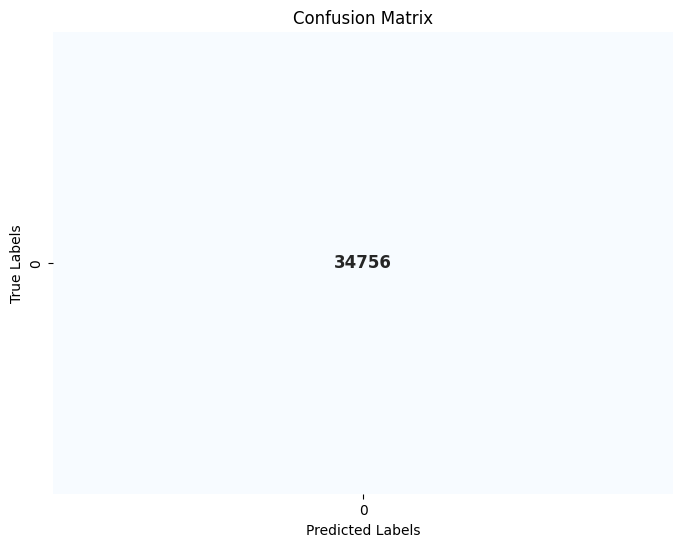

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**MODEL TESTING:**

In [ ]:
# Convert text to sequence of integers using tokenizer
sequence = tokenizer.texts_to_sequences(['He is a bad boy'])
# Pad sequences to ensure consistent length
test = pad_sequences(sequence, maxlen=max_len)
# Predict sentiment using the trained model
predict = model.predict(test)
# Determine sentiment based on predicted probability
if predict > 0.5:
    print("Positive")
else:
    print("Negative")

1/1 [==============================] - 0s 84ms/step
Negative
